<a href="https://colab.research.google.com/github/yingzibu/MOL2AE/blob/main/examples/ADME_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install rdkit --quiet
! pip install PyTDC --quiet
! pip install mycolorpy --quiet

!pip install dgllife --quiet
!pip install molvs --quiet

# !pip install dgl==1.1 --quiet # cpu version, usable for calculation

!pip uninstall dgl -y # dgl cuda version for training using gpu
!pip install  dgl -f https://data.dgl.ai/wheels/cu118/repo.html --quiet
!pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.3/91.3 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 6.9 MB/s eta

In [2]:
from sklearn.metrics import f1_score, accuracy_score, average_precision_score
from sklearn.metrics import confusion_matrix, roc_auc_score
import math

def get_preds(threshold, probabilities):
    try:
        if probabilities.shape[1] == 2: probabilities = probabilities[:, 1]
    except: pass
    return [1 if prob > threshold else 0 for prob in probabilities]

def evaluate_model(TP, FP, TN, FN):

    ACCURACY = (TP + TN) / (TP+FP+TN+FN)
    SE = TP/(TP+FN)
    recall = SE
    SP = TN/(TN+FP)
    weighted_accuracy = (SE + SP) / 2

    precision = TP / (TP + FP)
    SP = TN/(TN+FP)
    F1 = 2 * precision * recall /(precision + recall)

    temp = (TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)
    if temp != 0:
        MCC = (TP*TN-FP*FN)*1.0/(math.sqrt(temp))
    else:
        print('equation for MCC is (TP*TN-FP*FN)*1.0/(math.sqrt(temp))')
        print('TP, FP, TN, FN', TP, FP, TN, FN)
        print('temp=0')
        MCC = 'N/A'

    return ACCURACY,SE, SP, weighted_accuracy, precision, F1, MCC

def evaluate(y_real, y_hat, y_prob):
    TN, FP, FN, TP = confusion_matrix(y_real, y_hat).ravel()
    ACCURACY,SE, SP, weighted_accuracy, precision, F1, \
        MCC  = evaluate_model(TP, FP, TN, FN)
    try:
        if y_prob.shape[1] == 2: proba = y_prob[:, 1]
        else: proba = y_prob
    except: proba = y_prob
    AP = average_precision_score(y_real, proba)
    AUC = roc_auc_score(y_real, proba)
    print('Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP')
    if MCC != 'N/A':
        print("& %5.3f" % (ACCURACY), " &%7.3f" % (weighted_accuracy), " &%15.3f" % (precision),
      " &%10.3f" % (SE), " &%5.3f" % (SP), " &%5.3f" % (F1), "&%5.3f" % (AUC),
      "&%8.3f" % (MCC), "&%8.3f" % (AP))
    else:
        print("& %5.3f" % (ACCURACY), " &%7.3f" % (weighted_accuracy), " &%15.3f" % (precision),
      " &%10.3f" % (SE), " &%5.3f" % (SP), " &%5.3f" % (F1), "&%5.3f" % (AUC), "& ",
        MCC, "&%8.3f" % (AP))

    return ACCURACY, weighted_accuracy, precision, SE, SP, F1, AUC, MCC, AP


In [4]:
from rdkit import Chem
from rdkit.Chem.SaltRemover import SaltRemover
import pandas as pd
import numpy as np
from tqdm import tqdm
"Reference: https://github.com/Yimeng-Wang/JAK-MTATFP/blob/main/preprocess.py"

from molvs.normalize import Normalizer, Normalization
from molvs.charge import Reionizer, Uncharger
import torch.nn as nn

from tdc.single_pred import ADME
from rdkit import RDLogger
import warnings
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings("ignore")
MASK = -100


def preprocess(smi):
    mol = Chem.MolFromSmiles(smi)
    normalizer = Normalizer()
    new1 = normalizer.normalize(mol)
    remover = SaltRemover()
    new2 = remover(new1)
    neutralize1 = Reionizer()
    new3 = neutralize1(new2)
    neutralize2 = Uncharger()
    new4 = neutralize2(new3)
    new_smiles = Chem.MolToSmiles(new4, kekuleSmiles=False)
    return new_smiles

Absorption

In [20]:
name_reg = ['Half_Life_Obach', 'Clearance_Hepatocyte_AZ', 'VDss_Lombardo',
         'PPBR_AZ', 'Caco2_Wang', 'Lipophilicity_AstraZeneca',
         'HydrationFreeEnergy_FreeSolv', 'Solubility_AqSolDB']

name_cls = ['BBB_Martins', 'Bioavailability_Ma', 'Pgp_Broccatelli',
             'HIA_Hou', 'PAMPA_NCATS']

name_met_cls = ['CYP2C19_Veith', 'CYP2D6_Veith', 'CYP3A4_Veith',
                       'CYP1A2_Veith', 'CYP2C9_Veith',
                       'CYP2C9_Substrate_CarbonMangels',
                       'CYP2D6_Substrate_CarbonMangels',
                       'CYP3A4_Substrate_CarbonMangels']

# names = name_met_cls[:5] # metabolism

names = ['Lipophilicity_AstraZeneca', 'Solubility_AqSolDB', 'HydrationFreeEnergy_FreeSolv']
IS_R = True # is regression task
SCALE = False

if IS_R: loss_fn = nn.MSELoss(reduction='sum') # if regression
else: loss_fn = nn.BCEWithLogitsLoss(reduction='sum') # if classification

# If regression, metrics: R2, MAE, MSE, RMSE
# If classification, metrics: Loss, evaluate(y_real, y_hat, y_prob)

names, len(names)


(['Lipophilicity_AstraZeneca',
  'Solubility_AqSolDB',
  'HydrationFreeEnergy_FreeSolv'],
 3)

Found local copy...
Loading...
Done!


*************** Lipophilicity_AstraZeneca ***************


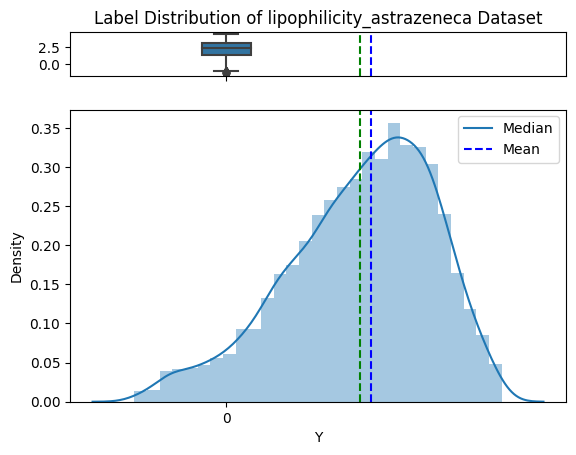

Cleaning mols: 100%|██████████| 840/840 [00:02<00:00, 317.61it/s]
Found local copy...
Loading...
Done!


*************** Solubility_AqSolDB ***************


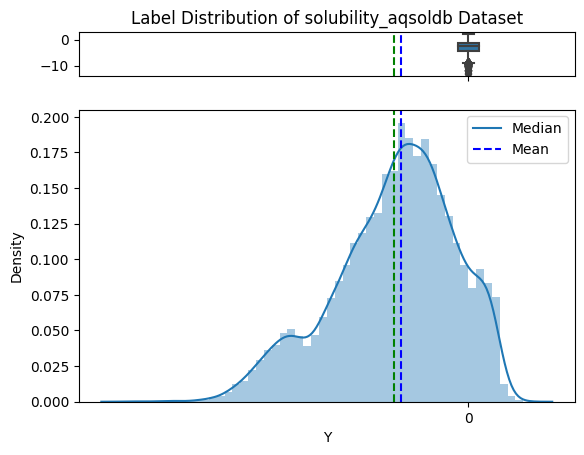

Cleaning mols: 100%|██████████| 1996/1996 [00:05<00:00, 388.62it/s]
Downloading...


*************** HydrationFreeEnergy_FreeSolv ***************


100%|██████████| 29.0k/29.0k [00:00<00:00, 127kiB/s] 
Loading...
Done!


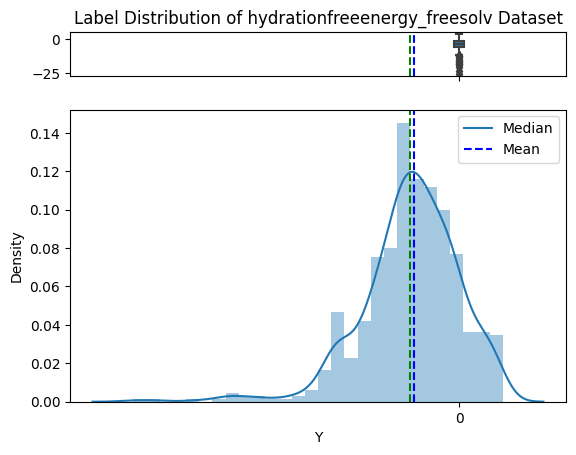

Cleaning mols: 100%|██████████| 128/128 [00:00<00:00, 471.83it/s]


(9989, 1474, 2934)

In [21]:
# from tdc.single_pred import ADME
# from rdkit import RDLogger
# import warnings
# RDLogger.DisableLog('rdApp.*')
# warnings.filterwarnings("ignore")
# MASK = -100

def rename_cols(df, name): return df.rename(columns={'Y':name})

def clean_mol(df:pd.DataFrame):
    prev_len = len(df)
    for i in tqdm(range(len(df)), total=len(df), desc='Cleaning mols'):
        try: df.iloc[i]['Drug'] = preprocess(df.iloc[i]['Drug'])
        except: df.drop(i)
    if len(df) != prev_len: print(f'prev len: {prev_len}; after clean: {len(df)}')
    return df.reset_index(drop=True)

def scal(df): # min max scaling
    # df_norm = df.loc[:, df.columns!='Drug'].copy()
    df_norm = df.copy()
    for col in df_norm.columns:
        if col == 'Drug': pass
        else:
            df_norm[col] = (df_norm[col]-df_norm[col].min()
            )/(df_norm[col].max()-df_norm[col].min()) * 10 + 1e-3
    # df_norm['Drug'] = df['Drug']
    return df_norm


for i, name in enumerate(names):
    print('*'*15, name, '*'*15)
    data = ADME(name=name)
    data.label_distribution()
    # data.convert_to_log(form='binding')

    # shoud not convert to log scale for the belowing since it is minus
    # Caco2_Wang                              -7.76
    # Lipophilicity_AstraZeneca               -1.45
    # HydrationFreeEnergy_FreeSolv           -23.62
    # Solubility_AqSolDB                   -13.1719

    split = data.get_split()
    train, valid = clean_mol(split['train']), clean_mol(split['valid'])
    test =  clean_mol(split['test'])

    train = rename_cols(train[['Drug', 'Y']], name)
    valid = rename_cols(valid[['Drug', 'Y']], name)
    test  = rename_cols(test[['Drug', 'Y']],  name)

    if IS_R and SCALE: train, valid, test = scal(train), scal(valid), scal(test)

    if i == 0: trains, valids, tests = train, valid, test
    else:
        trains = trains.merge(train, how='outer')
        valids = valids.merge(valid, how='outer')
        tests = tests.merge(test, how='outer')

# MASK = -100
# trains = trains.fillna(MASK)
# valids = valids.fillna(MASK)
# tests = tests.fillna(MASK)


# trains[trains.eq(0).any(1)]
# valids[valids.eq(0).any(1)]
# tests[tests.eq(0).any(1)]
len(trains), len(valids), len(tests)

In [22]:
import pandas as pd

import dgl
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from dgllife.model import model_zoo
from dgllife.utils import smiles_to_bigraph
from dgllife.utils import EarlyStopping, Meter
from dgllife.utils import AttentiveFPAtomFeaturizer
from dgllife.utils import AttentiveFPBondFeaturizer
from dgllife.data import MoleculeCSVDataset

def collate_molgraphs(data):
    assert len(data[0]) in [3, 4], \
        'Expect the tuple to be of length 3 or 4, got {:d}'.format(len(data[0]))
    if len(data[0]) == 3:
        smiles, graphs, labels = map(list, zip(*data))
        masks = None
    else:
        smiles, graphs, labels, masks = map(list, zip(*data))

    bg = dgl.batch(graphs)
    bg.set_n_initializer(dgl.init.zero_initializer)
    bg.set_e_initializer(dgl.init.zero_initializer)
    labels = torch.stack(labels, dim=0)

    if masks is None:
        masks = torch.ones(labels.shape)
    else:
        masks = torch.stack(masks, dim=0)
        # masks = (labels == MASK).long()
    return smiles, bg, labels, masks


atom_featurizer = AttentiveFPAtomFeaturizer(atom_data_field='hv')
bond_featurizer = AttentiveFPBondFeaturizer(bond_data_field='he')
n_feats_num = atom_featurizer.feat_size('hv')
e_feats_num = bond_featurizer.feat_size('he')

In [23]:
import time
named_tuple = time.localtime() # get struct_time
time_string = time.strftime("%m_%d_%Y_%H:%M:%S", named_tuple)

params = {'node_featurizer': atom_featurizer,
          'edge_featurizer': bond_featurizer,
          'smiles_column': 'Drug',
        #   'cache_file_path': time_string+'.bin',
          'task_names': names, 'load': True, 'n_jobs': len(names)}


train_datasets = MoleculeCSVDataset(trains, cache_file_path=f'train_{time_string}.bin', **params)
valid_datasets = MoleculeCSVDataset(valids,cache_file_path=f'valid_{time_string}.bin', **params)
test_datasets = MoleculeCSVDataset(tests, cache_file_path=f'test_{time_string}.bin', **params)

batch_size = 64
loader_params ={'batch_size': batch_size,
                'shuffle': True,
                'collate_fn': collate_molgraphs}

train_loader = DataLoader(train_datasets, **loader_params)
valid_loader = DataLoader(valid_datasets, **loader_params)
test_loader  = DataLoader(test_datasets,  **loader_params)

Processing dgl graphs from scratch...


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 103 tasks      | elapsed:    2.9s
[Parallel(n_jobs=3)]: Done 9167 tasks      | elapsed:   10.8s
[Parallel(n_jobs=3)]: Done 9989 out of 9989 | elapsed:   11.3s finished


Processing dgl graphs from scratch...


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 890 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 1474 out of 1474 | elapsed:    1.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Processing dgl graphs from scratch...


[Parallel(n_jobs=3)]: Done 890 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 2934 out of 2934 | elapsed:    3.0s finished


In [226]:
import time
def get_graph_dataset(df, name):
    atom_featurizer = AttentiveFPAtomFeaturizer(atom_data_field='hv')
    bond_featurizer = AttentiveFPBondFeaturizer(bond_data_field='he')
    n_feats_num = atom_featurizer.feat_size('hv')
    e_feats_num = bond_featurizer.feat_size('he')

    # named_tuple =  # get struct_time
    time_string = time.strftime("%m_%d_%Y_%H:%M:%S", time.localtime())

    params = {'node_featurizer': atom_featurizer,
            'edge_featurizer': bond_featurizer,
            'smiles_column': 'Drug',
            'cache_file_path': time_string+'.bin',
            'task_names': name, 'load': True, 'n_jobs': len(name)}
    graph_dataset = MoleculeCSVDataset(df, **params)
    return graph_dataset



In [96]:
cuda = torch.cuda.is_available()
if cuda: device = 'cuda'
else: device = 'cpu'
n_layers = 3
dropout = 0.5

model = model_zoo.AttentiveFPPredictor(
            node_feat_size=n_feats_num, edge_feat_size=e_feats_num,
            num_layers=n_layers, num_timesteps=1, graph_feat_size=300,
            n_tasks=len(names), dropout=dropout).to(device)

In [25]:
def train_epoch(epoch, model, data_loader, loss_func, optimizer):
    model.train()
    losses = 0
    train_meter = Meter()
    for batch_id, batch_data in tqdm(enumerate(data_loader),
                                     total=len(data_loader),
                                     desc=f'Epoch {epoch}'):
        smiles, bg, labels, masks = batch_data
        bg, labels, masks = bg.to(device), labels.to(device), masks.to(device)
        n_feats = bg.ndata.pop('hv').to(device)
        e_feats = bg.edata.pop('he').to(device)

        pred = model(bg, n_feats, e_feats)
        mask = masks < 1
        loss = loss_func(pred[~mask], labels[~mask])
        del mask
        # loss = (loss_func(pred, labels)*(masks!=0).float()).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_meter.update(pred, labels, masks)
        del pred
        del labels
        del masks
        losses += loss.item()
        # losses.append(loss.item())

    total_r2 = np.mean(train_meter.compute_metric('r2'))
    total_loss = losses / len(data_loader.dataset)
    # if epoch % 10 == 0 and epoch != 0:
    print(f'[Train] R2: {total_r2:.3f}, Loss: {total_loss:.3f}')

    return total_r2, total_loss

def eval_epoch(model, data_loader, loss_func):
    model.eval()
    val_losses = 0
    eval_meter = Meter()
    with torch.no_grad():
        for batch_data in data_loader:
            smiles, bg, labels, masks = batch_data
            bg, labels, masks = bg.to(device), labels.to(device), masks.to(device)
            n_feats = bg.ndata.pop('hv').to(device)
            e_feats = bg.edata.pop('he').to(device)
            val_pred = model(bg, n_feats, e_feats)
            mask = masks < 1
            val_loss = loss_func(val_pred[~mask], labels[~mask])
            # val_loss = (loss_func(val_pred, labels)*(masks!=0).float()).mean()
            # val_losses.append(val_loss.item())
            val_losses += val_loss.item()
            eval_meter.update(val_pred, labels, masks)
            del val_pred
            del labels
            del masks
            del n_feats
            del e_feats
        total_score = np.mean(eval_meter.compute_metric('r2'))
        total_loss = val_losses / len(data_loader.dataset)
        print(f'[Valid] R2: {total_score:.3f}, Loss: {total_loss:.3f}')
    return total_score, total_loss


In [26]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
stopper = EarlyStopping(mode='lower', patience=30)
n_epochs = 500
best_epoch = 0
min_loss = 100000

In [27]:
if best_epoch != 0:
    model.load_state_dict(torch.load('ckpt.pt', map_location=device))

for epoch in range(best_epoch, best_epoch + n_epochs):
    score = train_epoch(epoch, model, train_loader, loss_fn, optimizer)
    val_score = eval_epoch(model, valid_loader, loss_fn)
    early_stop = stopper.step(val_score[1], model)
    if val_score[1] < min_loss and epoch > 3:
        print(f'prev min loss {min_loss:.3f}, now better loss {val_score[1]:.3f}')
        min_loss = val_score[1]
        torch.save(model.state_dict(), 'ckpt.pt')
        print(f'save model at epoch: {epoch}')
        best_epoch = epoch

    if early_stop: print('early stop'); break


Epoch 0: 100%|██████████| 157/157 [00:03<00:00, 46.91it/s]


[Train] R2: 0.104, Loss: 4.272
[Valid] R2: 0.286, Loss: 2.641


Epoch 1: 100%|██████████| 157/157 [00:02<00:00, 52.48it/s]


[Train] R2: 0.321, Loss: 2.679
[Valid] R2: 0.542, Loss: 1.623


Epoch 2: 100%|██████████| 157/157 [00:02<00:00, 52.56it/s]


[Train] R2: 0.486, Loss: 2.004
[Valid] R2: 0.595, Loss: 1.395


Epoch 3: 100%|██████████| 157/157 [00:03<00:00, 50.92it/s]


[Train] R2: 0.538, Loss: 1.717
[Valid] R2: 0.631, Loss: 1.330


Epoch 4: 100%|██████████| 157/157 [00:03<00:00, 51.96it/s]


[Train] R2: 0.585, Loss: 1.566
[Valid] R2: 0.665, Loss: 1.220
prev min loss 100000.000, now better loss 1.220
save model at epoch: 4


Epoch 5: 100%|██████████| 157/157 [00:03<00:00, 52.32it/s]


[Train] R2: 0.604, Loss: 1.450
[Valid] R2: 0.677, Loss: 1.174
prev min loss 1.220, now better loss 1.174
save model at epoch: 5


Epoch 6: 100%|██████████| 157/157 [00:03<00:00, 51.42it/s]


[Train] R2: 0.619, Loss: 1.408
[Valid] R2: 0.685, Loss: 1.163
prev min loss 1.174, now better loss 1.163
save model at epoch: 6


Epoch 7: 100%|██████████| 157/157 [00:03<00:00, 51.30it/s]


[Train] R2: 0.639, Loss: 1.336
[Valid] R2: 0.702, Loss: 1.155
prev min loss 1.163, now better loss 1.155
save model at epoch: 7


Epoch 8: 100%|██████████| 157/157 [00:03<00:00, 52.19it/s]


[Train] R2: 0.657, Loss: 1.279
[Valid] R2: 0.710, Loss: 1.150
prev min loss 1.155, now better loss 1.150
save model at epoch: 8


Epoch 9: 100%|██████████| 157/157 [00:03<00:00, 52.11it/s]


[Train] R2: 0.665, Loss: 1.253
[Valid] R2: 0.717, Loss: 1.188
EarlyStopping counter: 1 out of 30


Epoch 10: 100%|██████████| 157/157 [00:03<00:00, 51.23it/s]


[Train] R2: 0.680, Loss: 1.213
[Valid] R2: 0.726, Loss: 1.075
prev min loss 1.150, now better loss 1.075
save model at epoch: 10


Epoch 11: 100%|██████████| 157/157 [00:03<00:00, 51.83it/s]


[Train] R2: 0.689, Loss: 1.199
[Valid] R2: 0.728, Loss: 1.038
prev min loss 1.075, now better loss 1.038
save model at epoch: 11


Epoch 12: 100%|██████████| 157/157 [00:03<00:00, 51.60it/s]


[Train] R2: 0.705, Loss: 1.133
[Valid] R2: 0.737, Loss: 1.083
EarlyStopping counter: 1 out of 30


Epoch 13: 100%|██████████| 157/157 [00:02<00:00, 53.14it/s]


[Train] R2: 0.713, Loss: 1.112
[Valid] R2: 0.751, Loss: 0.992
prev min loss 1.038, now better loss 0.992
save model at epoch: 13


Epoch 14: 100%|██████████| 157/157 [00:03<00:00, 50.92it/s]


[Train] R2: 0.723, Loss: 1.102
[Valid] R2: 0.749, Loss: 1.011
EarlyStopping counter: 1 out of 30


Epoch 15: 100%|██████████| 157/157 [00:03<00:00, 51.70it/s]


[Train] R2: 0.724, Loss: 1.096
[Valid] R2: 0.756, Loss: 0.975
prev min loss 0.992, now better loss 0.975
save model at epoch: 15


Epoch 16: 100%|██████████| 157/157 [00:03<00:00, 51.33it/s]


[Train] R2: 0.731, Loss: 1.074
[Valid] R2: 0.763, Loss: 0.953
prev min loss 0.975, now better loss 0.953
save model at epoch: 16


Epoch 17: 100%|██████████| 157/157 [00:03<00:00, 52.12it/s]


[Train] R2: 0.739, Loss: 1.038
[Valid] R2: 0.762, Loss: 0.947
prev min loss 0.953, now better loss 0.947
save model at epoch: 17


Epoch 18: 100%|██████████| 157/157 [00:03<00:00, 51.18it/s]


[Train] R2: 0.752, Loss: 1.000
[Valid] R2: 0.774, Loss: 0.926
prev min loss 0.947, now better loss 0.926
save model at epoch: 18


Epoch 19: 100%|██████████| 157/157 [00:03<00:00, 51.93it/s]


[Train] R2: 0.752, Loss: 0.997
[Valid] R2: 0.775, Loss: 0.926
prev min loss 0.926, now better loss 0.926
save model at epoch: 19


Epoch 20: 100%|██████████| 157/157 [00:02<00:00, 52.52it/s]


[Train] R2: 0.760, Loss: 0.981
[Valid] R2: 0.780, Loss: 0.917
prev min loss 0.926, now better loss 0.917
save model at epoch: 20


Epoch 21: 100%|██████████| 157/157 [00:03<00:00, 51.59it/s]


[Train] R2: 0.762, Loss: 0.975
[Valid] R2: 0.785, Loss: 0.907
prev min loss 0.917, now better loss 0.907
save model at epoch: 21


Epoch 22: 100%|██████████| 157/157 [00:03<00:00, 51.38it/s]


[Train] R2: 0.767, Loss: 0.948
[Valid] R2: 0.795, Loss: 0.875
prev min loss 0.907, now better loss 0.875
save model at epoch: 22


Epoch 23: 100%|██████████| 157/157 [00:03<00:00, 52.17it/s]


[Train] R2: 0.771, Loss: 0.945
[Valid] R2: 0.791, Loss: 0.902
EarlyStopping counter: 1 out of 30


Epoch 24: 100%|██████████| 157/157 [00:03<00:00, 51.86it/s]


[Train] R2: 0.775, Loss: 0.926
[Valid] R2: 0.793, Loss: 0.849
prev min loss 0.875, now better loss 0.849
save model at epoch: 24


Epoch 25: 100%|██████████| 157/157 [00:03<00:00, 48.90it/s]


[Train] R2: 0.773, Loss: 0.931
[Valid] R2: 0.799, Loss: 0.925
EarlyStopping counter: 1 out of 30


Epoch 26: 100%|██████████| 157/157 [00:02<00:00, 52.61it/s]


[Train] R2: 0.774, Loss: 0.909
[Valid] R2: 0.803, Loss: 0.856
EarlyStopping counter: 2 out of 30


Epoch 27: 100%|██████████| 157/157 [00:03<00:00, 51.78it/s]


[Train] R2: 0.784, Loss: 0.894
[Valid] R2: 0.797, Loss: 0.868
EarlyStopping counter: 3 out of 30


Epoch 28: 100%|██████████| 157/157 [00:03<00:00, 52.16it/s]


[Train] R2: 0.786, Loss: 0.882
[Valid] R2: 0.796, Loss: 0.939
EarlyStopping counter: 4 out of 30


Epoch 29: 100%|██████████| 157/157 [00:03<00:00, 51.53it/s]


[Train] R2: 0.793, Loss: 0.874
[Valid] R2: 0.811, Loss: 0.905
EarlyStopping counter: 5 out of 30


Epoch 30: 100%|██████████| 157/157 [00:03<00:00, 51.94it/s]


[Train] R2: 0.799, Loss: 0.850
[Valid] R2: 0.811, Loss: 0.827
prev min loss 0.849, now better loss 0.827
save model at epoch: 30


Epoch 31: 100%|██████████| 157/157 [00:02<00:00, 52.40it/s]


[Train] R2: 0.803, Loss: 0.850
[Valid] R2: 0.810, Loss: 0.841
EarlyStopping counter: 1 out of 30


Epoch 32: 100%|██████████| 157/157 [00:03<00:00, 52.07it/s]


[Train] R2: 0.806, Loss: 0.838
[Valid] R2: 0.811, Loss: 0.833
EarlyStopping counter: 2 out of 30


Epoch 33: 100%|██████████| 157/157 [00:03<00:00, 51.07it/s]


[Train] R2: 0.805, Loss: 0.840
[Valid] R2: 0.813, Loss: 0.851
EarlyStopping counter: 3 out of 30


Epoch 34: 100%|██████████| 157/157 [00:03<00:00, 51.56it/s]


[Train] R2: 0.809, Loss: 0.826
[Valid] R2: 0.812, Loss: 0.865
EarlyStopping counter: 4 out of 30


Epoch 35: 100%|██████████| 157/157 [00:03<00:00, 51.44it/s]


[Train] R2: 0.812, Loss: 0.808
[Valid] R2: 0.810, Loss: 0.836
EarlyStopping counter: 5 out of 30


Epoch 36: 100%|██████████| 157/157 [00:03<00:00, 50.84it/s]


[Train] R2: 0.805, Loss: 0.825
[Valid] R2: 0.810, Loss: 0.850
EarlyStopping counter: 6 out of 30


Epoch 37: 100%|██████████| 157/157 [00:03<00:00, 51.98it/s]


[Train] R2: 0.818, Loss: 0.795
[Valid] R2: 0.824, Loss: 0.814
prev min loss 0.827, now better loss 0.814
save model at epoch: 37


Epoch 38: 100%|██████████| 157/157 [00:02<00:00, 52.53it/s]


[Train] R2: 0.820, Loss: 0.775
[Valid] R2: 0.823, Loss: 0.871
EarlyStopping counter: 1 out of 30


Epoch 39: 100%|██████████| 157/157 [00:02<00:00, 52.44it/s]


[Train] R2: 0.821, Loss: 0.781
[Valid] R2: 0.810, Loss: 0.854
EarlyStopping counter: 2 out of 30


Epoch 40: 100%|██████████| 157/157 [00:03<00:00, 50.82it/s]


[Train] R2: 0.821, Loss: 0.779
[Valid] R2: 0.827, Loss: 0.833
EarlyStopping counter: 3 out of 30


Epoch 41: 100%|██████████| 157/157 [00:03<00:00, 52.02it/s]


[Train] R2: 0.827, Loss: 0.759
[Valid] R2: 0.824, Loss: 0.805
prev min loss 0.814, now better loss 0.805
save model at epoch: 41


Epoch 42: 100%|██████████| 157/157 [00:02<00:00, 52.46it/s]


[Train] R2: 0.826, Loss: 0.759
[Valid] R2: 0.832, Loss: 0.795
prev min loss 0.805, now better loss 0.795
save model at epoch: 42


Epoch 43: 100%|██████████| 157/157 [00:03<00:00, 49.78it/s]


[Train] R2: 0.828, Loss: 0.750
[Valid] R2: 0.829, Loss: 0.820
EarlyStopping counter: 1 out of 30


Epoch 44: 100%|██████████| 157/157 [00:03<00:00, 51.25it/s]


[Train] R2: 0.834, Loss: 0.737
[Valid] R2: 0.832, Loss: 0.813
EarlyStopping counter: 2 out of 30


Epoch 45: 100%|██████████| 157/157 [00:03<00:00, 51.99it/s]


[Train] R2: 0.829, Loss: 0.734
[Valid] R2: 0.828, Loss: 0.821
EarlyStopping counter: 3 out of 30


Epoch 46: 100%|██████████| 157/157 [00:03<00:00, 51.91it/s]


[Train] R2: 0.834, Loss: 0.726
[Valid] R2: 0.830, Loss: 0.790
prev min loss 0.795, now better loss 0.790
save model at epoch: 46


Epoch 47: 100%|██████████| 157/157 [00:03<00:00, 51.18it/s]


[Train] R2: 0.836, Loss: 0.728
[Valid] R2: 0.836, Loss: 0.824
EarlyStopping counter: 1 out of 30


Epoch 48: 100%|██████████| 157/157 [00:03<00:00, 51.57it/s]


[Train] R2: 0.838, Loss: 0.714
[Valid] R2: 0.837, Loss: 0.835
EarlyStopping counter: 2 out of 30


Epoch 49: 100%|██████████| 157/157 [00:03<00:00, 52.26it/s]


[Train] R2: 0.836, Loss: 0.705
[Valid] R2: 0.839, Loss: 0.793
EarlyStopping counter: 3 out of 30


Epoch 50: 100%|██████████| 157/157 [00:03<00:00, 52.21it/s]


[Train] R2: 0.839, Loss: 0.702
[Valid] R2: 0.838, Loss: 0.800
EarlyStopping counter: 4 out of 30


Epoch 51: 100%|██████████| 157/157 [00:03<00:00, 50.33it/s]


[Train] R2: 0.841, Loss: 0.702
[Valid] R2: 0.838, Loss: 0.774
prev min loss 0.790, now better loss 0.774
save model at epoch: 51


Epoch 52: 100%|██████████| 157/157 [00:03<00:00, 50.22it/s]


[Train] R2: 0.843, Loss: 0.695
[Valid] R2: 0.836, Loss: 0.786
EarlyStopping counter: 1 out of 30


Epoch 53: 100%|██████████| 157/157 [00:03<00:00, 51.96it/s]


[Train] R2: 0.850, Loss: 0.673
[Valid] R2: 0.836, Loss: 0.773
prev min loss 0.774, now better loss 0.773
save model at epoch: 53


Epoch 54: 100%|██████████| 157/157 [00:03<00:00, 51.48it/s]


[Train] R2: 0.850, Loss: 0.671
[Valid] R2: 0.844, Loss: 0.820
EarlyStopping counter: 1 out of 30


Epoch 55: 100%|██████████| 157/157 [00:03<00:00, 50.06it/s]


[Train] R2: 0.841, Loss: 0.690
[Valid] R2: 0.847, Loss: 0.783
EarlyStopping counter: 2 out of 30


Epoch 56: 100%|██████████| 157/157 [00:02<00:00, 52.72it/s]


[Train] R2: 0.853, Loss: 0.662
[Valid] R2: 0.842, Loss: 0.823
EarlyStopping counter: 3 out of 30


Epoch 57: 100%|██████████| 157/157 [00:03<00:00, 52.02it/s]


[Train] R2: 0.850, Loss: 0.659
[Valid] R2: 0.842, Loss: 0.762
prev min loss 0.773, now better loss 0.762
save model at epoch: 57


Epoch 58: 100%|██████████| 157/157 [00:03<00:00, 50.57it/s]


[Train] R2: 0.850, Loss: 0.661
[Valid] R2: 0.836, Loss: 0.832
EarlyStopping counter: 1 out of 30


Epoch 59: 100%|██████████| 157/157 [00:03<00:00, 50.58it/s]


[Train] R2: 0.859, Loss: 0.638
[Valid] R2: 0.843, Loss: 0.757
prev min loss 0.762, now better loss 0.757
save model at epoch: 59


Epoch 60: 100%|██████████| 157/157 [00:03<00:00, 51.42it/s]


[Train] R2: 0.854, Loss: 0.661
[Valid] R2: 0.850, Loss: 0.771
EarlyStopping counter: 1 out of 30


Epoch 61: 100%|██████████| 157/157 [00:03<00:00, 50.07it/s]


[Train] R2: 0.858, Loss: 0.651
[Valid] R2: 0.847, Loss: 0.778
EarlyStopping counter: 2 out of 30


Epoch 62: 100%|██████████| 157/157 [00:03<00:00, 50.65it/s]


[Train] R2: 0.860, Loss: 0.625
[Valid] R2: 0.852, Loss: 0.746
prev min loss 0.757, now better loss 0.746
save model at epoch: 62


Epoch 63: 100%|██████████| 157/157 [00:03<00:00, 50.90it/s]


[Train] R2: 0.857, Loss: 0.643
[Valid] R2: 0.848, Loss: 0.789
EarlyStopping counter: 1 out of 30


Epoch 64: 100%|██████████| 157/157 [00:03<00:00, 51.30it/s]


[Train] R2: 0.860, Loss: 0.635
[Valid] R2: 0.842, Loss: 0.782
EarlyStopping counter: 2 out of 30


Epoch 65: 100%|██████████| 157/157 [00:03<00:00, 51.42it/s]


[Train] R2: 0.859, Loss: 0.626
[Valid] R2: 0.849, Loss: 0.795
EarlyStopping counter: 3 out of 30


Epoch 66: 100%|██████████| 157/157 [00:03<00:00, 50.55it/s]


[Train] R2: 0.861, Loss: 0.622
[Valid] R2: 0.841, Loss: 0.818
EarlyStopping counter: 4 out of 30


Epoch 67: 100%|██████████| 157/157 [00:03<00:00, 50.58it/s]


[Train] R2: 0.865, Loss: 0.615
[Valid] R2: 0.846, Loss: 0.782
EarlyStopping counter: 5 out of 30


Epoch 68: 100%|██████████| 157/157 [00:03<00:00, 50.92it/s]


[Train] R2: 0.859, Loss: 0.619
[Valid] R2: 0.848, Loss: 0.781
EarlyStopping counter: 6 out of 30


Epoch 69: 100%|██████████| 157/157 [00:03<00:00, 50.97it/s]


[Train] R2: 0.868, Loss: 0.606
[Valid] R2: 0.843, Loss: 0.775
EarlyStopping counter: 7 out of 30


Epoch 70: 100%|██████████| 157/157 [00:03<00:00, 49.96it/s]


[Train] R2: 0.862, Loss: 0.619
[Valid] R2: 0.847, Loss: 0.781
EarlyStopping counter: 8 out of 30


Epoch 71: 100%|██████████| 157/157 [00:03<00:00, 50.83it/s]


[Train] R2: 0.863, Loss: 0.607
[Valid] R2: 0.848, Loss: 0.766
EarlyStopping counter: 9 out of 30


Epoch 72: 100%|██████████| 157/157 [00:03<00:00, 51.86it/s]


[Train] R2: 0.868, Loss: 0.591
[Valid] R2: 0.846, Loss: 0.808
EarlyStopping counter: 10 out of 30


Epoch 73: 100%|██████████| 157/157 [00:03<00:00, 50.00it/s]


[Train] R2: 0.873, Loss: 0.583
[Valid] R2: 0.849, Loss: 0.756
EarlyStopping counter: 11 out of 30


Epoch 74: 100%|██████████| 157/157 [00:03<00:00, 52.03it/s]


[Train] R2: 0.869, Loss: 0.593
[Valid] R2: 0.850, Loss: 0.781
EarlyStopping counter: 12 out of 30


Epoch 75: 100%|██████████| 157/157 [00:03<00:00, 52.16it/s]


[Train] R2: 0.869, Loss: 0.594
[Valid] R2: 0.843, Loss: 0.806
EarlyStopping counter: 13 out of 30


Epoch 76: 100%|██████████| 157/157 [00:03<00:00, 51.58it/s]


[Train] R2: 0.869, Loss: 0.582
[Valid] R2: 0.850, Loss: 0.773
EarlyStopping counter: 14 out of 30


Epoch 77: 100%|██████████| 157/157 [00:03<00:00, 49.71it/s]


[Train] R2: 0.876, Loss: 0.569
[Valid] R2: 0.844, Loss: 0.787
EarlyStopping counter: 15 out of 30


Epoch 78: 100%|██████████| 157/157 [00:03<00:00, 51.62it/s]


[Train] R2: 0.874, Loss: 0.565
[Valid] R2: 0.850, Loss: 0.811
EarlyStopping counter: 16 out of 30


Epoch 79: 100%|██████████| 157/157 [00:03<00:00, 50.90it/s]


[Train] R2: 0.873, Loss: 0.566
[Valid] R2: 0.844, Loss: 0.771
EarlyStopping counter: 17 out of 30


Epoch 80: 100%|██████████| 157/157 [00:03<00:00, 50.30it/s]


[Train] R2: 0.872, Loss: 0.572
[Valid] R2: 0.844, Loss: 0.777
EarlyStopping counter: 18 out of 30


Epoch 81: 100%|██████████| 157/157 [00:03<00:00, 50.40it/s]


[Train] R2: 0.879, Loss: 0.552
[Valid] R2: 0.848, Loss: 0.788
EarlyStopping counter: 19 out of 30


Epoch 82: 100%|██████████| 157/157 [00:03<00:00, 51.01it/s]


[Train] R2: 0.876, Loss: 0.561
[Valid] R2: 0.847, Loss: 0.782
EarlyStopping counter: 20 out of 30


Epoch 83: 100%|██████████| 157/157 [00:03<00:00, 51.59it/s]


[Train] R2: 0.879, Loss: 0.547
[Valid] R2: 0.854, Loss: 0.769
EarlyStopping counter: 21 out of 30


Epoch 84: 100%|██████████| 157/157 [00:03<00:00, 48.09it/s]


[Train] R2: 0.876, Loss: 0.556
[Valid] R2: 0.851, Loss: 0.770
EarlyStopping counter: 22 out of 30


Epoch 85: 100%|██████████| 157/157 [00:03<00:00, 50.50it/s]


[Train] R2: 0.885, Loss: 0.537
[Valid] R2: 0.851, Loss: 0.791
EarlyStopping counter: 23 out of 30


Epoch 86: 100%|██████████| 157/157 [00:03<00:00, 50.72it/s]


[Train] R2: 0.881, Loss: 0.539
[Valid] R2: 0.848, Loss: 0.780
EarlyStopping counter: 24 out of 30


Epoch 87: 100%|██████████| 157/157 [00:03<00:00, 50.50it/s]


[Train] R2: 0.881, Loss: 0.533
[Valid] R2: 0.854, Loss: 0.773
EarlyStopping counter: 25 out of 30


Epoch 88: 100%|██████████| 157/157 [00:03<00:00, 48.94it/s]


[Train] R2: 0.882, Loss: 0.527
[Valid] R2: 0.845, Loss: 0.814
EarlyStopping counter: 26 out of 30


Epoch 89: 100%|██████████| 157/157 [00:03<00:00, 51.31it/s]


[Train] R2: 0.885, Loss: 0.526
[Valid] R2: 0.853, Loss: 0.778
EarlyStopping counter: 27 out of 30


Epoch 90: 100%|██████████| 157/157 [00:03<00:00, 51.54it/s]


[Train] R2: 0.877, Loss: 0.542
[Valid] R2: 0.850, Loss: 0.792
EarlyStopping counter: 28 out of 30


Epoch 91: 100%|██████████| 157/157 [00:03<00:00, 51.31it/s]


[Train] R2: 0.884, Loss: 0.520
[Valid] R2: 0.856, Loss: 0.755
EarlyStopping counter: 29 out of 30


Epoch 92: 100%|██████████| 157/157 [00:03<00:00, 51.20it/s]


[Train] R2: 0.886, Loss: 0.509
[Valid] R2: 0.850, Loss: 0.783
EarlyStopping counter: 30 out of 30
early stop


In [323]:
model = model_zoo.AttentiveFPPredictor(
            node_feat_size=n_feats_num, edge_feat_size=e_feats_num,
            num_layers=n_layers, num_timesteps=1, graph_feat_size=300,
            n_tasks=len(names)).to(device)

model.load_state_dict(torch.load('ckpt.pt', map_location=device))


<All keys matched successfully>

In [29]:
import sklearn.metrics as metrics


def reg_evaluate(label_clean, preds_clean):
    mae = metrics.mean_absolute_error(label_clean, preds_clean)
    mse = metrics.mean_squared_error(label_clean, preds_clean)
    rmse = np.sqrt(mse) #mse**(0.5)
    r2 = metrics.r2_score(label_clean, preds_clean)

    # print("Overall results of sklearn.metrics:")
    print("MAE:",mae)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("R-Squared:", r2)

    eval_result_r2 =   f'R2:     {r2:.3f}'
    eval_result_mae =  f'MAE:   {mae:.3f}'
    eval_result_rmse = f'RMSE: {rmse:.3f}'

    return eval_result_r2, eval_result_mae, eval_result_rmse


Evaluate on test sets
using MSELoss


100%|██████████| 46/46 [00:02<00:00, 16.66it/s]


total_loss: 0.798

OVERALL

 R2: 	0.842 +/- 0.091 
 MAE: 	0.537 +/- 0.082 
 RMSE: 	0.803 +/- 0.149

SEPERATELY

*************** Lipophilicity ***************
MAE: 0.46137884
MSE: 0.38369226
RMSE: 0.619429
R-Squared: 0.7403052999475366
-1.7470000386238098 4.786999762058258 -1.0924603790044785 4.490451619029045 6.533999800682068 5.582911998033524


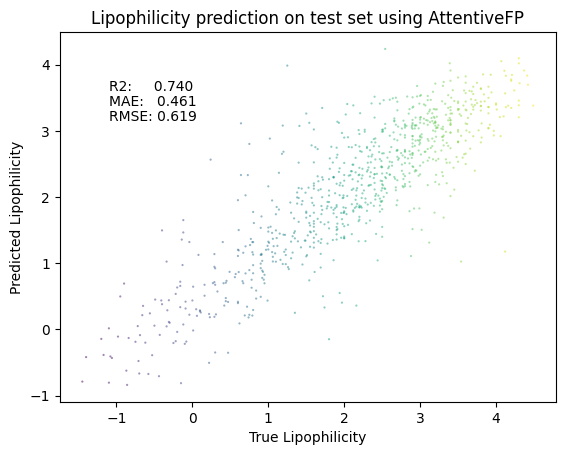

*************** Solubility ***************
MAE: 0.6510906
MSE: 0.96934736
RMSE: 0.9845544
R-Squared: 0.8213740411042436
-13.68254559636116 2.433461719751358 -14.748629879951476 2.16707022190094 16.11600731611252 16.915700101852416


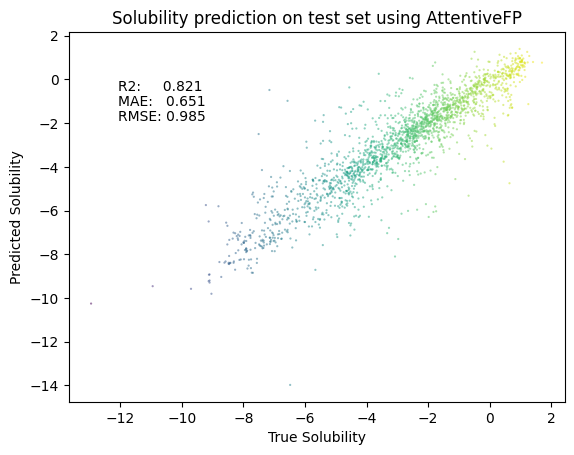

*************** HydrationFreeEnergy ***************
MAE: 0.49712804
MSE: 0.64929944
RMSE: 0.8057912
R-Squared: 0.9602845801914166
-24.972500884532927 4.7825001120567325 -24.75773491859436 4.442691469192505 29.755000996589658 29.200426387786862


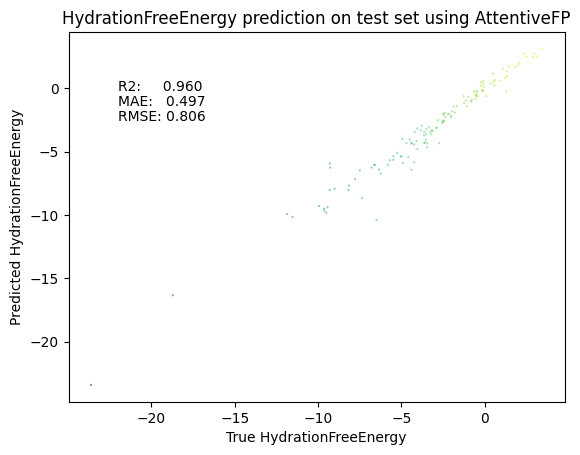

In [339]:
print('Evaluate on test sets')
model = model.cpu()
model.eval()
total_loss = 0
test_meter = Meter()
if IS_R: print('using MSELoss')
else: print('using BCELOSSwithdigits')

for i, batch_data in tqdm(enumerate(test_loader), total=len(test_loader)):
    smiles, bg, labels, masks = batch_data
    # bg, labels, masks = bg.to(device), labels.to(device), masks.to(device)
    # n_feats = bg.ndata.pop('hv').to(device)
    # e_feats = bg.edata.pop('he').to(device)
    n_feats = bg.ndata.pop('hv')
    e_feats = bg.edata.pop('he')

    pred = model(bg, n_feats, e_feats)
    # loss = (loss_fn(pred, labels)*(masks!=0).float()).mean()
    mask = masks < 1
    loss = loss_fn(pred[~mask], labels[~mask])
    test_meter.update(pred, labels, masks)
    # print(loss)
    total_loss += loss.item()
    if i == 0:
        preds_ = pred.cpu()
        labels_ = labels.cpu()
        masks_ = mask.cpu()
    else:
        preds_ = torch.cat([preds_, pred.cpu()], dim=0)
        labels_ = torch.cat([labels_, labels.cpu()], dim=0)
        masks_ = torch.cat([masks_, mask.cpu()], dim=0)
# masks_ = masks_ < 1
# preds_, labels_ = preds_.detach().numpy(), labels_.detach().numpy()
total_loss /= len(tests)
print(f'total_loss: {total_loss:.3f}')

from mycolorpy import colorlist as mcp
import matplotlib.pyplot as plt

if IS_R: # regression task
    r2 = test_meter.compute_metric('r2')
    r2_mean, r2_std = np.mean(r2), np.std(r2)
    # r2_avg = test_meter.compute_metric('r2', reduction='mean')
    mae = test_meter.compute_metric('mae')
    mae_mean, mae_std = np.mean(mae), np.std(mae)
    # mae_avg = test_meter.compute_metric('mae', reduction='mean')
    rmse = test_meter.compute_metric('rmse')
    rmse_mean, rmse_std = np.mean(rmse), np.std(rmse)
    # # rmse_avg = test_meter.compute_metric('rmse', reduction='mean')
    print('\nOVERALL\n')
    print(f' R2: \t{r2_mean:.3f} +/- {r2_std:.3f} \n',
        f'MAE: \t{mae_mean:.3f} +/- {mae_std:.3f} \n',
        f'RMSE: \t{rmse_mean:.3f} +/- {rmse_std:.3f}')

    print('\nSEPERATELY\n')
    for i, name in enumerate(names):

        try: name = name.split('_')[0]
        except: pass
        print('*'*15, name, '*'*15)
        fig = plt.figure()
        r2, mae, rmse = reg_evaluate(
                labels_[:, i][~masks_[:, i]].detach().numpy(),
                 preds_[:, i][~masks_[:, i]].detach().numpy())
        color = mcp.gen_color_normalized(cmap='viridis',
                data_arr=labels_[:, i][~masks_[:, i]].detach().numpy())

        plt.scatter(labels_[:, i][~masks_[:, i]].detach().numpy(),
                    preds_[:, i][~masks_[:, i]].detach().numpy(),
                    cmap='viridis', marker='.',
                    s=10, alpha=0.5, edgecolors='none', c=color)
        plt.xlabel(f'True {name}')
        plt.ylabel(f'Predicted {name}')
        plt.title(f'{name} prediction on test set using AttentiveFP')


        x0, xmax = plt.xlim()
        y0, ymax = plt.ylim()
        data_width = xmax - x0
        data_height = ymax - y0
        # print(x0, xmax, y0, ymax, data_width, data_height)
        plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8/0.95, r2)
        plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8,  mae)
        plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8*0.95, rmse)

        plt.show()
        plt.cla()
        plt.clf()
        plt.close()



if IS_R == False:
    for i, name in enumerate(names):
        try: name = name.split('_')[0]
        except: pass
        print('*'*15, name, '*'*15)
        probs = F.sigmoid(preds_[:, i][~masks_[:, i]])
        label = labels_[:, i][~masks_[:, i]]
        probs = probs.cpu().detach().numpy()
        label = label.cpu().detach().numpy()
        assert len(probs) == len(label)
        preds = get_preds(0.5, probs)
        evaluate(label, preds, probs)
        print()


In [32]:
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem.MACCSkeys import GenMACCSKeys
import torch.nn.functional as F

m = Chem.MolFromSmiles
header = ['bit' + str(i) for i in range(167)]

def smile_list_to_MACCS(smi_list:list):
    MACCS_list = []
    for smi in smi_list:
        maccs = [float(i) for i in list(GenMACCSKeys(m(smi)).ToBitString())]
        MACCS_list.append(maccs)
    return MACCS_list

def process(data):

    # data = convert_with_qed_sa(data)
    print('---> converting SMILES to MACCS...')
    MACCS_list = smile_list_to_MACCS(data['Drug'].tolist())
    data[header] = pd.DataFrame(MACCS_list)
    print('---> FINISHED')
    return data

MASK = -100

class nn_dataset(Dataset):
    def __init__(self, df, prop_names, mask=MASK):
        super(nn_dataset, self).__init__()
        df = process(df)
        df = df.fillna(mask)
        self.df = df
        self.len = len(df)
        self.fp = self.df[header]
        self.props = self.df[prop_names]

    def __getitem__(self, idx):
        fp = torch.tensor(self.fp.iloc[idx], dtype=torch.float32)
        label = torch.tensor(self.props.iloc[idx], dtype=torch.float32)
        return fp, label

    def __len__(self): return self.len

    def get_df(self): return self.df

In [33]:
batch_size = 64
params_nn = {'batch_size': batch_size, 'shuffle': True,
          'drop_last': False, 'num_workers': 0}

train_loader_nn = DataLoader(nn_dataset(trains, names), **params_nn)
valid_loader_nn = DataLoader(nn_dataset(valids, names), **params_nn)
test_loader_nn  = DataLoader(nn_dataset(tests,  names), **params_nn)

---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED


In [188]:
class Classifier(nn.Module):
    def __init__(self, dims):
        super(Classifier, self).__init__()
        [in_dim, h_dims, out_dim] = dims
        self.dims = dims
        neurons = [in_dim, *h_dims]
        linear_layers = [nn.Linear(neurons[i-1], neurons[i]) \
                         for i in range(1, len(neurons))]
        self.hidden = nn.ModuleList(linear_layers)
        self.final = nn.Linear(h_dims[-1], out_dim)

    def forward(self, x):
        for layer in self.hidden:
            x = F.relu(layer(x))
        x = self.final(x)
        return x

    def get_dim(self): return self.dims



import matplotlib.pyplot as plt

def get_min(d:dict):
    min_key = next(iter(d))

    # Iterate over the keys in the dictionary
    for key in d:
        # If the value of the current key > the value of max_key, update max_key
        if d[key] < d[min_key]:
            min_key = key
    return min_key, d[min_key]

def plot_loss(train_dict, test_dict, name='test'):
    fig = plt.figure()
    plt.plot(list(train_dict.keys()), list(train_dict.values()), label='train')
    plt.plot(list(test_dict.keys()), list(test_dict.values()), label=name)
    argmin, min = get_min(test_dict)
    plt.plot(argmin, min, '*', label=f'min epoch {argmin}')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('loss during training')
    plt.legend()
    plt.show()


In [91]:
in_dim = 167 # len of fingerprint
out_dim = len(names)
hid_dims = [128, 64, 32, 16] # hidden dims changeable

dims = [in_dim, hid_dims, out_dim]
dims

[167, [128, 64, 32, 16], 3]

In [92]:
model = Classifier(dims)
from torchsummary import summary

cuda = torch.cuda.is_available()

if cuda:
    model = model.cuda()
    device = 'cuda'
else: device = 'cpu'
summary(model, (batch_size, in_dim))

if IS_R: loss_function = nn.MSELoss(reduction='sum'); loss_label = 'MSE'
else: loss_function = nn.BCEWithLogitsLoss(reduction='sum'); loss_label = 'BCE'
lr = 3e-4
wd = 1e-5
train_loss_dict = {}
valid_loss_dict = {}

epochs = 100
best_epoch = 0

optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr, weight_decay=wd)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 64, 128]          21,504
            Linear-2               [-1, 64, 64]           8,256
            Linear-3               [-1, 64, 32]           2,080
            Linear-4               [-1, 64, 16]             528
            Linear-5                [-1, 64, 3]              51
Total params: 32,419
Trainable params: 32,419
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.12
Params size (MB): 0.12
Estimated Total Size (MB): 0.28
----------------------------------------------------------------


Epoch 0: 100%|██████████| 157/157 [00:01<00:00, 81.81it/s]


[Train] MSE loss: 7.663
[Valid] MSE loss: 3.916


Epoch 1: 100%|██████████| 157/157 [00:01<00:00, 82.06it/s]


[Train] MSE loss: 3.552
[Valid] MSE loss: 2.846


Epoch 2: 100%|██████████| 157/157 [00:01<00:00, 79.19it/s]


[Train] MSE loss: 2.935
[Valid] MSE loss: 2.533


Epoch 3: 100%|██████████| 157/157 [00:02<00:00, 77.65it/s]


[Train] MSE loss: 2.521
[Valid] MSE loss: 2.222


Epoch 4: 100%|██████████| 157/157 [00:01<00:00, 83.43it/s]


[Train] MSE loss: 2.155
[Valid] MSE loss: 2.105
Save model at epoch 4
prev min loss 2.222, now min loss 2.105


Epoch 5: 100%|██████████| 157/157 [00:01<00:00, 83.44it/s]


[Train] MSE loss: 1.958
[Valid] MSE loss: 2.021
Save model at epoch 5
prev min loss 2.105, now min loss 2.021


Epoch 6: 100%|██████████| 157/157 [00:01<00:00, 83.53it/s]


[Train] MSE loss: 1.846
[Valid] MSE loss: 2.121


Epoch 7: 100%|██████████| 157/157 [00:01<00:00, 80.66it/s]


[Train] MSE loss: 1.769
[Valid] MSE loss: 1.936
Save model at epoch 7
prev min loss 2.021, now min loss 1.936


Epoch 8: 100%|██████████| 157/157 [00:01<00:00, 83.07it/s]


[Train] MSE loss: 1.698
[Valid] MSE loss: 1.843
Save model at epoch 8
prev min loss 1.936, now min loss 1.843


Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 82.77it/s]


[Train] MSE loss: 1.619
[Valid] MSE loss: 1.810
Save model at epoch 9
prev min loss 1.843, now min loss 1.810


Epoch 10: 100%|██████████| 157/157 [00:01<00:00, 83.93it/s]


[Train] MSE loss: 1.570
[Valid] MSE loss: 1.774
Save model at epoch 10
prev min loss 1.810, now min loss 1.774


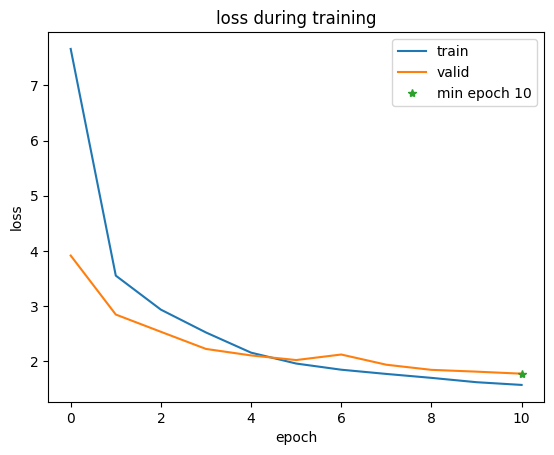

Epoch 11: 100%|██████████| 157/157 [00:01<00:00, 82.51it/s]


[Train] MSE loss: 1.528
[Valid] MSE loss: 1.720
Save model at epoch 11
prev min loss 1.774, now min loss 1.720


Epoch 12: 100%|██████████| 157/157 [00:01<00:00, 80.77it/s]


[Train] MSE loss: 1.494
[Valid] MSE loss: 1.761


Epoch 13: 100%|██████████| 157/157 [00:01<00:00, 79.66it/s]


[Train] MSE loss: 1.450
[Valid] MSE loss: 1.704
Save model at epoch 13
prev min loss 1.720, now min loss 1.704


Epoch 14: 100%|██████████| 157/157 [00:01<00:00, 82.10it/s]


[Train] MSE loss: 1.404
[Valid] MSE loss: 1.656
Save model at epoch 14
prev min loss 1.704, now min loss 1.656


Epoch 15: 100%|██████████| 157/157 [00:01<00:00, 83.10it/s]


[Train] MSE loss: 1.374
[Valid] MSE loss: 1.680


Epoch 16: 100%|██████████| 157/157 [00:01<00:00, 81.84it/s]


[Train] MSE loss: 1.334
[Valid] MSE loss: 1.617
Save model at epoch 16
prev min loss 1.656, now min loss 1.617


Epoch 17: 100%|██████████| 157/157 [00:01<00:00, 81.86it/s]


[Train] MSE loss: 1.298
[Valid] MSE loss: 1.588
Save model at epoch 17
prev min loss 1.617, now min loss 1.588


Epoch 18: 100%|██████████| 157/157 [00:01<00:00, 80.63it/s]


[Train] MSE loss: 1.279
[Valid] MSE loss: 1.595


Epoch 19: 100%|██████████| 157/157 [00:01<00:00, 80.84it/s]


[Train] MSE loss: 1.246
[Valid] MSE loss: 1.555
Save model at epoch 19
prev min loss 1.588, now min loss 1.555


Epoch 20: 100%|██████████| 157/157 [00:01<00:00, 82.48it/s]


[Train] MSE loss: 1.215
[Valid] MSE loss: 1.556


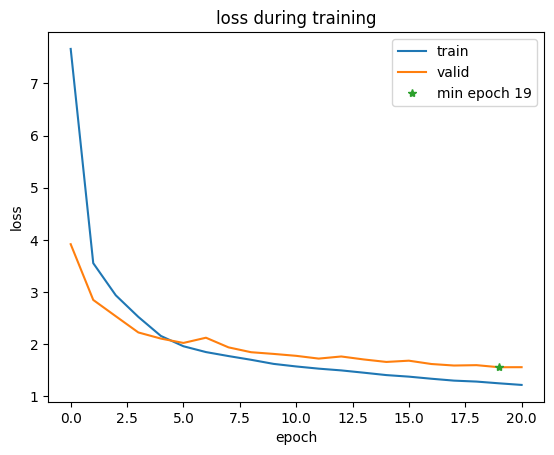

Epoch 21: 100%|██████████| 157/157 [00:01<00:00, 84.03it/s]


[Train] MSE loss: 1.198
[Valid] MSE loss: 1.551
Save model at epoch 21
prev min loss 1.555, now min loss 1.551


Epoch 22: 100%|██████████| 157/157 [00:01<00:00, 82.66it/s]


[Train] MSE loss: 1.173
[Valid] MSE loss: 1.534
Save model at epoch 22
prev min loss 1.551, now min loss 1.534


Epoch 23: 100%|██████████| 157/157 [00:01<00:00, 82.16it/s]


[Train] MSE loss: 1.142
[Valid] MSE loss: 1.659


Epoch 24: 100%|██████████| 157/157 [00:01<00:00, 78.63it/s]


[Train] MSE loss: 1.128
[Valid] MSE loss: 1.498
Save model at epoch 24
prev min loss 1.534, now min loss 1.498


Epoch 25: 100%|██████████| 157/157 [00:01<00:00, 82.72it/s]


[Train] MSE loss: 1.100
[Valid] MSE loss: 1.608


Epoch 26: 100%|██████████| 157/157 [00:01<00:00, 84.88it/s]


[Train] MSE loss: 1.087
[Valid] MSE loss: 1.543


Epoch 27: 100%|██████████| 157/157 [00:01<00:00, 84.01it/s]


[Train] MSE loss: 1.056
[Valid] MSE loss: 1.437
Save model at epoch 27
prev min loss 1.498, now min loss 1.437


Epoch 28: 100%|██████████| 157/157 [00:01<00:00, 80.41it/s]


[Train] MSE loss: 1.037
[Valid] MSE loss: 1.435
Save model at epoch 28
prev min loss 1.437, now min loss 1.435


Epoch 29: 100%|██████████| 157/157 [00:01<00:00, 82.68it/s]


[Train] MSE loss: 1.031
[Valid] MSE loss: 1.439


Epoch 30: 100%|██████████| 157/157 [00:01<00:00, 80.22it/s]


[Train] MSE loss: 1.003
[Valid] MSE loss: 1.465


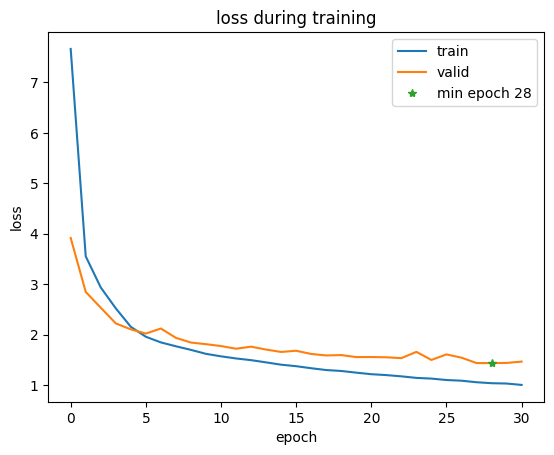

Epoch 31: 100%|██████████| 157/157 [00:01<00:00, 80.98it/s]


[Train] MSE loss: 0.991
[Valid] MSE loss: 1.528


Epoch 32: 100%|██████████| 157/157 [00:01<00:00, 82.73it/s]


[Train] MSE loss: 0.979
[Valid] MSE loss: 1.493


Epoch 33: 100%|██████████| 157/157 [00:01<00:00, 82.83it/s]


[Train] MSE loss: 0.974
[Valid] MSE loss: 1.578


Epoch 34: 100%|██████████| 157/157 [00:01<00:00, 83.76it/s]


[Train] MSE loss: 0.946
[Valid] MSE loss: 1.428
Save model at epoch 34
prev min loss 1.435, now min loss 1.428


Epoch 35: 100%|██████████| 157/157 [00:01<00:00, 79.48it/s]


[Train] MSE loss: 0.937
[Valid] MSE loss: 1.448


Epoch 36: 100%|██████████| 157/157 [00:01<00:00, 82.18it/s]


[Train] MSE loss: 0.912
[Valid] MSE loss: 1.476


Epoch 37: 100%|██████████| 157/157 [00:01<00:00, 84.62it/s]


[Train] MSE loss: 0.915
[Valid] MSE loss: 1.425
Save model at epoch 37
prev min loss 1.428, now min loss 1.425


Epoch 38: 100%|██████████| 157/157 [00:01<00:00, 83.25it/s]


[Train] MSE loss: 0.897
[Valid] MSE loss: 1.422
Save model at epoch 38
prev min loss 1.425, now min loss 1.422


Epoch 39: 100%|██████████| 157/157 [00:01<00:00, 83.28it/s]


[Train] MSE loss: 0.885
[Valid] MSE loss: 1.491


Epoch 40: 100%|██████████| 157/157 [00:01<00:00, 81.14it/s]


[Train] MSE loss: 0.879
[Valid] MSE loss: 1.551


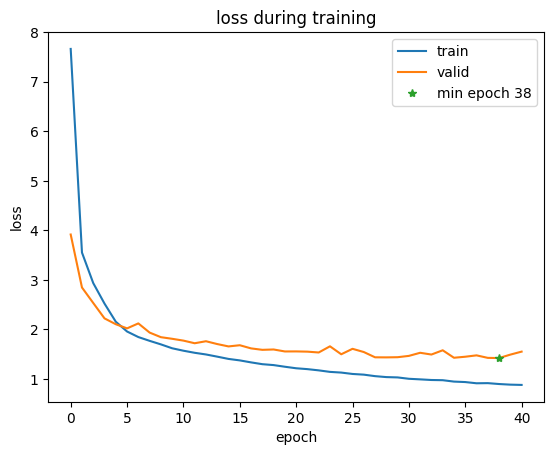

Epoch 41: 100%|██████████| 157/157 [00:01<00:00, 80.02it/s]


[Train] MSE loss: 0.869
[Valid] MSE loss: 1.398
Save model at epoch 41
prev min loss 1.422, now min loss 1.398


Epoch 42: 100%|██████████| 157/157 [00:01<00:00, 82.51it/s]


[Train] MSE loss: 0.842
[Valid] MSE loss: 1.376
Save model at epoch 42
prev min loss 1.398, now min loss 1.376


Epoch 43: 100%|██████████| 157/157 [00:01<00:00, 82.00it/s]


[Train] MSE loss: 0.840
[Valid] MSE loss: 1.423


Epoch 44: 100%|██████████| 157/157 [00:01<00:00, 80.18it/s]


[Train] MSE loss: 0.830
[Valid] MSE loss: 1.429


Epoch 45: 100%|██████████| 157/157 [00:01<00:00, 81.46it/s]


[Train] MSE loss: 0.828
[Valid] MSE loss: 1.454


Epoch 46: 100%|██████████| 157/157 [00:01<00:00, 78.97it/s]


[Train] MSE loss: 0.801
[Valid] MSE loss: 1.399


Epoch 47: 100%|██████████| 157/157 [00:01<00:00, 80.33it/s]


[Train] MSE loss: 0.804
[Valid] MSE loss: 1.408


Epoch 48: 100%|██████████| 157/157 [00:01<00:00, 82.02it/s]


[Train] MSE loss: 0.788
[Valid] MSE loss: 1.434


Epoch 49: 100%|██████████| 157/157 [00:01<00:00, 82.05it/s]


[Train] MSE loss: 0.772
[Valid] MSE loss: 1.421


Epoch 50: 100%|██████████| 157/157 [00:01<00:00, 81.00it/s]


[Train] MSE loss: 0.761
[Valid] MSE loss: 1.422


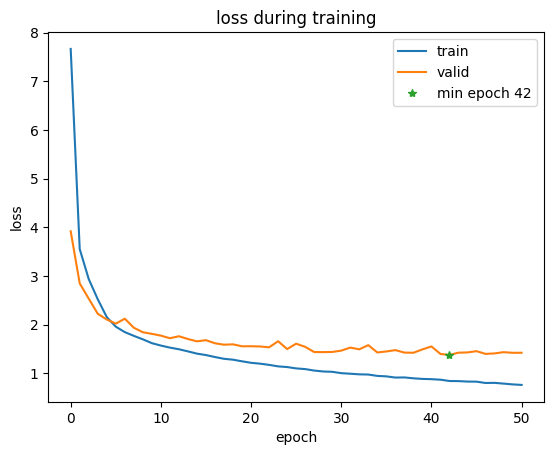

Epoch 51: 100%|██████████| 157/157 [00:01<00:00, 80.92it/s]


[Train] MSE loss: 0.765
[Valid] MSE loss: 1.465


Epoch 52: 100%|██████████| 157/157 [00:02<00:00, 75.42it/s]


[Train] MSE loss: 0.741
[Valid] MSE loss: 1.430


Epoch 53: 100%|██████████| 157/157 [00:01<00:00, 81.13it/s]


[Train] MSE loss: 0.739
[Valid] MSE loss: 1.377


Epoch 54: 100%|██████████| 157/157 [00:01<00:00, 81.29it/s]


[Train] MSE loss: 0.740
[Valid] MSE loss: 1.459


Epoch 55: 100%|██████████| 157/157 [00:01<00:00, 82.05it/s]


[Train] MSE loss: 0.722
[Valid] MSE loss: 1.426


Epoch 56: 100%|██████████| 157/157 [00:01<00:00, 78.57it/s]


[Train] MSE loss: 0.727
[Valid] MSE loss: 1.399


Epoch 57: 100%|██████████| 157/157 [00:01<00:00, 79.64it/s]


[Train] MSE loss: 0.715
[Valid] MSE loss: 1.397


Epoch 58: 100%|██████████| 157/157 [00:01<00:00, 78.91it/s]


[Train] MSE loss: 0.704
[Valid] MSE loss: 1.404


Epoch 59: 100%|██████████| 157/157 [00:01<00:00, 82.19it/s]


[Train] MSE loss: 0.694
[Valid] MSE loss: 1.455


Epoch 60: 100%|██████████| 157/157 [00:01<00:00, 80.69it/s]


[Train] MSE loss: 0.697
[Valid] MSE loss: 1.486


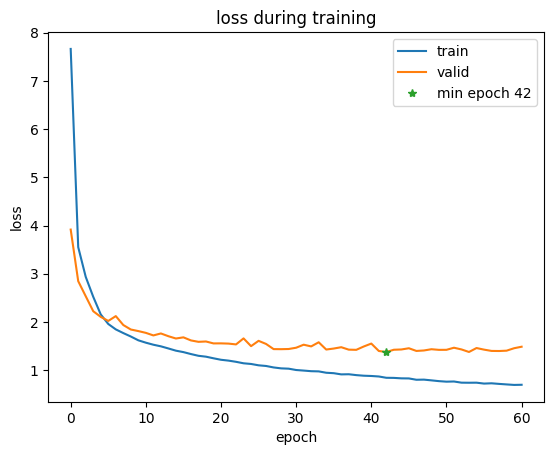

Epoch 61: 100%|██████████| 157/157 [00:01<00:00, 82.08it/s]


[Train] MSE loss: 0.678
[Valid] MSE loss: 1.419


Epoch 62: 100%|██████████| 157/157 [00:01<00:00, 82.87it/s]


[Train] MSE loss: 0.673
[Valid] MSE loss: 1.534


Epoch 63: 100%|██████████| 157/157 [00:02<00:00, 77.89it/s]


[Train] MSE loss: 0.667
[Valid] MSE loss: 1.433
early stop, no decrease


In [93]:
if best_epoch != 0:
    model.load_state_dict(torch.load('ckpt_nn.pt', map_location=device))

for epoch in range(best_epoch, epochs+best_epoch):
    total_loss = 0
    model.train()
    for i, (fp, label) in tqdm(enumerate(train_loader_nn),
                               total=len(train_loader_nn),
                               desc=f'Epoch {epoch}'):
        optimizer.zero_grad()
        if cuda: fp, label = fp.cuda(), label.cuda()
        mask = label == MASK
        output = model(fp)
        loss = loss_function(output[~mask], label[~mask])
        # r2 = metrics.r2_score(label[~mask].cpu().detach().numpy(),
        #                       output[~mask].cpu().detach().numpy())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    total_loss /= len(train_loader_nn.dataset)
    print(f'[Train] {loss_label} loss: {total_loss:.3f}')
    train_loss_dict[epoch] = total_loss

    model.eval()
    total_valid_loss = 0
    for fp, label in valid_loader_nn:
        if cuda: fp, label = fp.cuda(), label.cuda()
        mask = label == MASK
        output = model(fp)
        loss = loss_function(output[~mask], label[~mask])
        # r2 = metrics.r2_score(label[~mask].cpu().detach().numpy(),
        #                       output[~mask].cpu().detach().numpy())
        total_valid_loss += loss.item()
    total_valid_loss /= len(valid_loader_nn.dataset)
    print(f'[Valid] {loss_label} loss: {total_valid_loss:.3f}')
    try: argmin, min_loss = get_min(valid_loss_dict)
    except: argmin, min_loss = -1, 10000
    if total_valid_loss <= min_loss and epoch > 3:
        # SAVE MODEL
        print('Save model at epoch', epoch)
        torch.save(model.state_dict(), 'ckpt_nn.pt')
        best_epoch = epoch
        print(f'prev min loss {min_loss:.3f}, now min loss {total_valid_loss:.3f}')

    valid_loss_dict[epoch] = total_valid_loss

    if epoch - argmin > 20: print('early stop, no decrease'); break
    if total_valid_loss / min_loss > 1.5: print('loss increase'); break

    if epoch % 10 == 0 and epoch != 0:
        plot_loss(train_loss_dict, valid_loss_dict, name='valid')

In [94]:
print('Evaluate on test sets')
model = Classifier(dims).to(device)
model.load_state_dict(torch.load('ckpt_nn.pt', map_location=device))
model.eval()
total_loss = 0
test_meter = Meter()


for i, (fp, labels) in enumerate(test_loader_nn):
    fp, labels = fp.to(device), labels.to(device)
    mask = labels == MASK
    pred = model(fp)
    loss = loss_function(pred[~mask], labels[~mask])

    total_loss += loss.item()
    if i == 0:
        preds_ = pred.cpu()
        labels_ = labels.cpu()
        masks_ = mask.cpu()
    else:
        preds_ = torch.cat([preds_, pred.cpu()], dim=0)
        labels_ = torch.cat([labels_, labels.cpu()], dim=0)
        masks_ = torch.cat([masks_, mask.cpu()], dim=0)
total_loss /= len(test_loader_nn.dataset)
print(f'total_loss: {total_loss}')


if IS_R: reg_evaluate(labels_[~masks_].detach().numpy(),
                      preds_[~masks_].detach().numpy())
else:
    evaluate(labels_[~masks_].detach().numpy(),
             get_preds(0.5, F.sigmoid(preds_[~masks_]).detach().numpy()),
             preds_[~masks_].detach().numpy())

Evaluate on test sets
total_loss: 1.3674672080614003
MAE: 0.8477339
MSE: 1.3536265
RMSE: 1.1634545
R-Squared: 0.8648455379908901


*************** Lipophilicity ***************
MAE: 0.7160229
MSE: 0.8258849
RMSE: 0.90878206
R-Squared: 0.44101585250897435


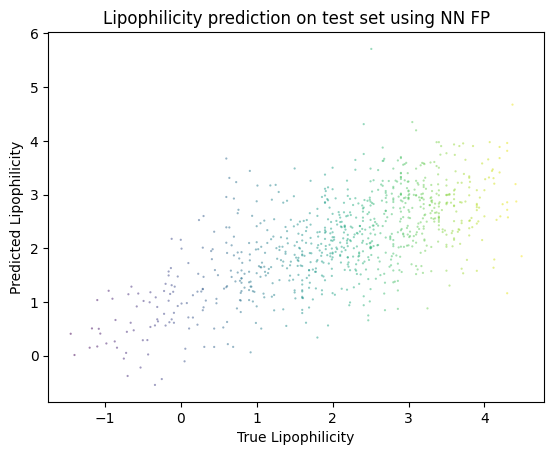

*************** Solubility ***************
MAE: 0.90782356
MSE: 1.5699635
RMSE: 1.2529818
R-Squared: 0.7106958834214798


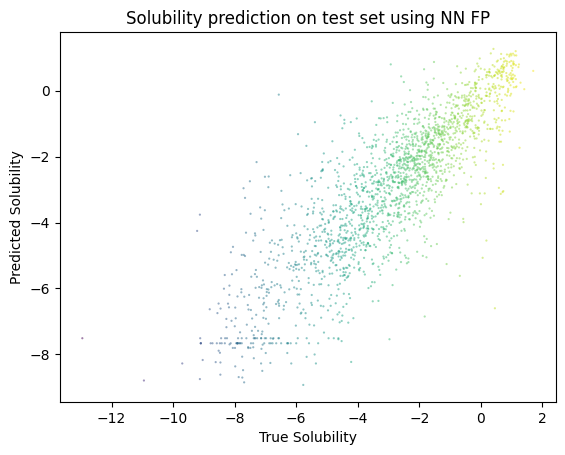

*************** HydrationFreeEnergy ***************
MAE: 0.7750648
MSE: 1.4434273
RMSE: 1.2014272
R-Squared: 0.911710501128275


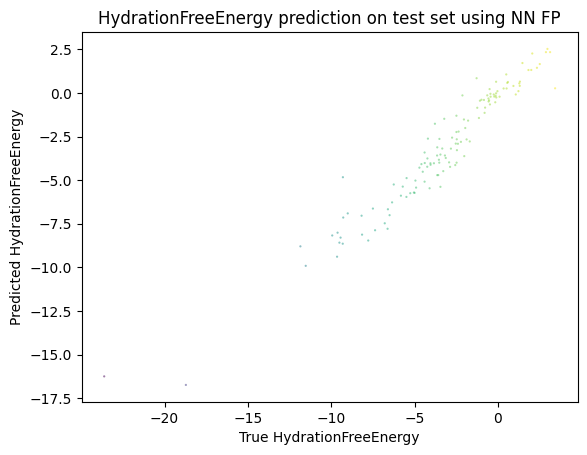

In [95]:
for i, name in enumerate(names):
    try: name = name.split('_')[0]
    except: pass
    print('*'*15, name, '*'*15)
    e_r2, e_mae, e_rmse = reg_evaluate(
                 labels_[:, i][~masks_[:, i]].detach().numpy(),
                 preds_[:, i][~masks_[:, i]].detach().numpy())

    color = mcp.gen_color_normalized(cmap='viridis',
                data_arr=labels_[:, i][~masks_[:, i]].detach().numpy())
    plt.scatter(labels_[:, i][~masks_[:, i]].detach().numpy(),
                preds_[:, i][~masks_[:, i]].detach().numpy(),
                cmap='viridis', marker='.',
                s=10, alpha=0.5, edgecolors='none', c=color)
    plt.xlabel(f'True {name}')
    plt.ylabel(f'Predicted {name}')
    plt.title(f'{name} prediction on test set using NN FP')
    # plt.text(-12, 1, e_r2)
    # plt.text(-12, 0, e_mae)
    # plt.text(-12, -1, e_rmse)
    plt.show()
    plt.close()

Transfer learning

In [ ]:
class Transfer_Classifier(nn.Module):
    def __init__(self, dims, pre_model):
        super(Transfer_Classifier, self).__init__()

        [in_dim, h_dims, out_dim] = dims
        assert len(h_dims) >= 2
        self.dims = dims
        neurons = [in_dim, *h_dims]
        linear_layers = [nn.Linear(neurons[i-1], neurons[i]) \
                         for i in range(1, len(neurons))]
        self.hidden = nn.ModuleList(linear_layers)
        self.model = pre_model
        self.device = next(pre_model.parameters()).device.type
        self.pre_model_out_dim = pre_model.predict[1].out_features
        # self.hid_2 = nn.Linear(h_dims[-1], h_dims[-1] + self.pre_model_out_dim)
        # self.final1 = nn.Linear(h_dims[-] + )

        self.final = nn.Linear(h_dims[-1], out_dim)
        self.with_pre_cal = nn.Linear(self.pre_model_out_dim + out_dim, out_dim)

    def forward_pretrained(self, bg):
        self.model.eval()
        n = bg.ndata.pop('hv').to(self.device)
        e = bg.edata.pop('he').to(self.device)
        return self.model(bg, n, e)

    def forward(self, x, bg=None):
        for layer in self.hidden:
            x = F.relu(layer(x))
        x = self.final(x)
        # self.model.eval()
        if bg != None:
            y = self.forward_pretrained(bg)
            x = torch.cat([x, y], dim=1)
            x = self.with_pre_cal(x)

        # print(x.shape, y.shape)
        # x = x.reshape()
        # x = torch.cat([x, y], dim=1)


        # return F.relu(self.final2(x))
        return x

in_dim = 167 # len of fingerprint
out_dim = len(names)
hid_dims = [128, 64, 32, 16] # hidden dims changeable, len should > 2

dims = [in_dim, hid_dims, out_dim]


graph_model = model_zoo.AttentiveFPPredictor(
            node_feat_size=n_feats_num, edge_feat_size=e_feats_num,
            num_layers=n_layers, num_timesteps=1, graph_feat_size=300,
            n_tasks=len(names)).to(device)

graph_model.load_state_dict(torch.load('ckpt.pt', map_location=device))

model = Transfer_Classifier(dims, graph_model).to(device)
model

In [316]:
def train_epoch(epoch, model, data_loader, loss_func, optimizer):
    model.train()
    losses = 0
    train_meter = Meter()
    for batch_id, batch_data in tqdm(enumerate(data_loader),
                                     total=len(data_loader),
                                     desc=f'Epoch {epoch}'):
        optimizer.zero_grad()
        fp, bg, labels, masks = batch_data
        pred = model(fp,bg)
        mask = masks < 1
        loss = loss_func(pred[~mask], labels[~mask])
        del mask
        loss.backward()
        optimizer.step()
        train_meter.update(pred, labels, masks)
        del pred
        del labels
        del masks
        losses += loss.item()
    total_r2 = np.mean(train_meter.compute_metric('r2'))
    total_loss = losses / len(data_loader.dataset)
    print(f'[Train] R2: {total_r2:.3f}, {loss_label} loss: {total_loss:.3f}')
    return total_r2, total_loss

def eval_epoch(model, data_loader, loss_func):
    model.eval()
    val_losses = 0
    eval_meter = Meter()
    with torch.no_grad():
        for batch_data in data_loader:
            fp, bg, labels, masks = batch_data
            pred = model(fp,bg)
            mask = masks < 1
            val_loss = loss_func(pred[~mask], labels[~mask])
            val_losses += val_loss.item()
            eval_meter.update(pred, labels, masks)
            del pred
            del labels
            del mask
            del masks
        total_score = np.mean(eval_meter.compute_metric('r2'))
        total_loss = val_losses / len(data_loader.dataset)
        print(f'[Valid] R2: {total_score:.3f}, {loss_label} loss: {total_loss:.3f}')
    return total_score, total_loss

In [232]:
class FP_graph_dataset(Dataset):
    def __init__(self, df, prop_names, device):
        super(FP_graph_dataset, self).__init__()

        # self.graph_dataset = MoleculeCSVDataset(df, cache_file_path=f'train_{time_string}.bin', **params)
        df = process(df)
        self.graph_dataset = get_graph_dataset(df, prop_names)

        # df = df.fillna(mask)
        # self.df = df
        self.len = len(df)
        # self.name = prop_names
        # self.fp = self.df[header]
        self.device = device

    def __getitem__(self, idx):
        _, graph, label, mask = self.graph_dataset[idx]
        fp = torch.tensor(self.graph_dataset.df[header].iloc[idx], dtype=torch.float32)
        return fp.to(device), graph.to(device), label.to(device), mask.to(device)

    def __len__(self): return self.len

# ea = FP_graph_dataset(tests, names, device)
# ea[10]

def collate_fp_graph(data):
    fp, bg, labels, masks = collate_molgraphs(data)
    return torch.stack(fp, dim=0), bg, labels, masks

fp_graph_params ={'batch_size': batch_size,
                'shuffle': False,
                'collate_fn': collate_fp_graph}

train_loader_tr = DataLoader(FP_graph_dataset(trains, names, device), **fp_graph_params)
valid_loader_tr = DataLoader(FP_graph_dataset(valids, names, device), **fp_graph_params)
test_loader_tr  = DataLoader(FP_graph_dataset(tests,  names, device), **fp_graph_params)

---> converting SMILES to MACCS...
---> FINISHED
Processing dgl graphs from scratch...


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 140 tasks      | elapsed:    2.9s
[Parallel(n_jobs=3)]: Done 9356 tasks      | elapsed:   11.4s
[Parallel(n_jobs=3)]: Done 9984 out of 9989 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done 9989 out of 9989 | elapsed:   11.8s finished


---> converting SMILES to MACCS...
---> FINISHED
Processing dgl graphs from scratch...


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 890 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 1474 out of 1474 | elapsed:    1.1s finished


---> converting SMILES to MACCS...
---> FINISHED
Processing dgl graphs from scratch...


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 890 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 2934 out of 2934 | elapsed:    3.6s finished


In [317]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
stopper = EarlyStopping(mode='lower', patience=30)
n_epochs = 500
best_epoch = 0
min_loss = 100000

In [319]:
if best_epoch != 0:
    model.load_state_dict(torch.load('ckpt_tr.pt', map_location=device))

for epoch in range(best_epoch, best_epoch + n_epochs):
    score = train_epoch(epoch, model, train_loader_tr, loss_fn, optimizer)
    val_score = eval_epoch(model, valid_loader_tr, loss_fn)
    early_stop = stopper.step(val_score[1], model)
    if val_score[1] < min_loss and epoch > 3:
        print(f'prev min loss {min_loss:.3f}, now better loss {val_score[1]:.3f}')
        min_loss = val_score[1]
        torch.save(model.state_dict(), 'ckpt_tr.pt')
        print(f'save model at epoch: {epoch}')
        best_epoch = epoch

    if early_stop: print('early stop'); break

Epoch 48: 100%|██████████| 157/157 [00:34<00:00,  4.55it/s]


[Train] R2: 0.951, MSE loss: 0.253
[Valid] R2: 0.846912, MSE loss: 0.927
EarlyStopping counter: 10 out of 30


Epoch 49:  15%|█▍        | 23/157 [00:05<00:29,  4.51it/s]


KeyboardInterrupt: ignored

Evaluate on test sets
using MSELoss


100%|██████████| 46/46 [00:05<00:00,  8.70it/s]


total_loss: 1.012

OVERALL

 R2: 	0.830 +/- 0.088 
 MAE: 	0.601 +/- 0.077 
 RMSE: 	0.909 +/- 0.170

SEPERATELY

*************** Lipophilicity ***************
MAE: 0.5378549
MSE: 0.48213893
RMSE: 0.6943622
R-Squared: 0.6736735916385174


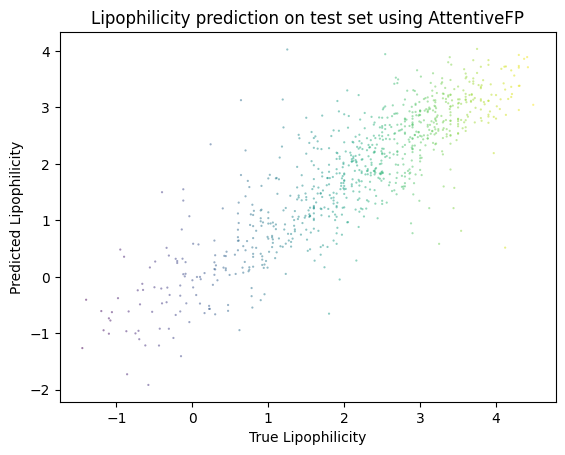

*************** Solubility ***************
MAE: 0.7098237
MSE: 1.2299974
RMSE: 1.1090524
R-Squared: 0.773342913547279


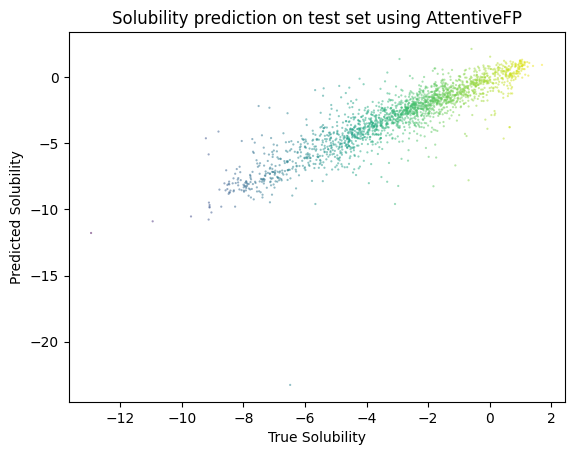

*************** HydrationFreeEnergy ***************
MAE: 0.55513716
MSE: 0.85158056
RMSE: 0.9228112
R-Squared: 0.9479117358961122


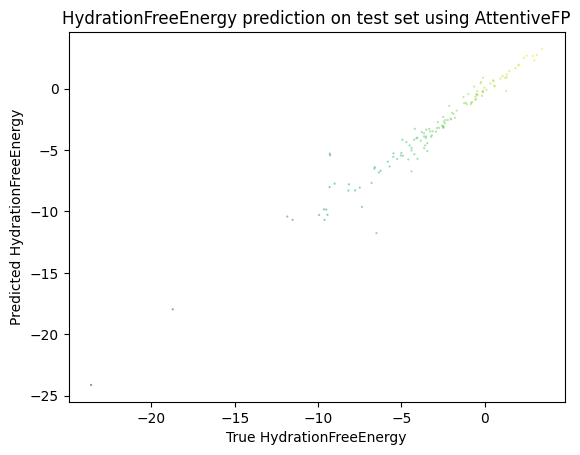

In [322]:
graph_model = model_zoo.AttentiveFPPredictor(
            node_feat_size=n_feats_num, edge_feat_size=e_feats_num,
            num_layers=n_layers, num_timesteps=1, graph_feat_size=300,
            n_tasks=len(names)).to(device)

graph_model.load_state_dict(torch.load('ckpt.pt', map_location=device))

model = Transfer_Classifier(dims, graph_model).to(device)
model.load_state_dict(torch.load('ckpt_tr.pt', map_location=device))

print('Evaluate on test sets')
model.eval()
total_loss = 0
test_meter = Meter()

if IS_R: print('using MSELoss')
else: print('using BCELOSSwithdigits')

for i, batch_data in tqdm(enumerate(test_loader_tr), total=len(test_loader_tr)):
    fp, bg, labels, masks = batch_data

    pred = model(fp, bg)
    # loss = (loss_fn(pred, labels)*(masks!=0).float()).mean()
    mask =masks < 1
    loss = loss_fn(pred[~mask], labels[~mask])
    test_meter.update(pred.cpu(), labels.cpu(), masks.cpu())
    # print(loss)
    total_loss += loss.item()
    if i == 0:
        preds_ = pred.cpu()
        labels_ = labels.cpu()
        masks_ = mask.cpu()
    else:
        preds_ = torch.cat([preds_, pred.cpu()], dim=0)
        labels_ = torch.cat([labels_, labels.cpu()], dim=0)
        masks_ = torch.cat([masks_, mask.cpu()], dim=0)
# masks_ = masks_ < 1
# preds_, labels_ = preds_.detach().numpy(), labels_.detach().numpy()
total_loss /= len(tests)
print(f'total_loss: {total_loss:.3f}')

from mycolorpy import colorlist as mcp
import matplotlib.pyplot as plt

if IS_R: # regression task
    r2 = test_meter.compute_metric('r2')
    r2_mean, r2_std = np.mean(r2), np.std(r2)
    # r2_avg = test_meter.compute_metric('r2', reduction='mean')
    mae = test_meter.compute_metric('mae')
    mae_mean, mae_std = np.mean(mae), np.std(mae)
    # mae_avg = test_meter.compute_metric('mae', reduction='mean')
    rmse = test_meter.compute_metric('rmse')
    rmse_mean, rmse_std = np.mean(rmse), np.std(rmse)
    # # rmse_avg = test_meter.compute_metric('rmse', reduction='mean')
    print('\nOVERALL\n')
    print(f' R2: \t{r2_mean:.3f} +/- {r2_std:.3f} \n',
        f'MAE: \t{mae_mean:.3f} +/- {mae_std:.3f} \n',
        f'RMSE: \t{rmse_mean:.3f} +/- {rmse_std:.3f}')

    print('\nSEPERATELY\n')
    for i, name in enumerate(names):

        try: name = name.split('_')[0]
        except: pass
        print('*'*15, name, '*'*15)
        fig = plt.plot()
        r2, mae, rmse = reg_evaluate(
                labels_[:, i][~masks_[:, i]].detach().numpy(),
                 preds_[:, i][~masks_[:, i]].detach().numpy())
        color = mcp.gen_color_normalized(cmap='viridis',
                data_arr=labels_[:, i][~masks_[:, i]].detach().numpy())
        plt.scatter(labels_[:, i][~masks_[:, i]].detach().numpy(),
                    preds_[:, i][~masks_[:, i]].detach().numpy(),
                    cmap='viridis', marker='.',
                    s=10, alpha=0.5, edgecolors='none', c=color)
        plt.xlabel(f'True {name}')
        plt.ylabel(f'Predicted {name}')
        plt.title(f'{name} prediction on test set using AttentiveFP')
        # plt.text(-12, 1, e_r2)
        # plt.text(-12, 0, e_mae)
        # plt.text(-12, -1, e_rmse)
        plt.show()
        plt.close()


if IS_R == False:
    for i, name in enumerate(names):
        try: name = name.split('_')[0]
        except: pass
        print('*'*15, name, '*'*15)
        probs = F.sigmoid(preds_[:, i][~masks_[:, i]])
        label = labels_[:, i][~masks_[:, i]]
        probs = probs.cpu().detach().numpy()
        label = label.cpu().detach().numpy()
        assert len(probs) == len(label)
        preds = get_preds(0.5, probs)
        evaluate(label, preds, probs)
        print()
